# Generate material id, river sections for PFLOTRAN

## set working dir

In [1]:
setwd("/Users/shua784/Dropbox/PNNL/Projects/Reach_scale_model/")
paste("Working dir: ", getwd())

[1] "Working dir:  /Users/shua784/Dropbox/PNNL/Projects/Reach_scale_model"

In [2]:
install.packages("pacman")
pacman::p_load(fields, AtmRay, maptools, raster, plot3D, rhdf5, scatterplot3d, akima, rgl, gtools, sp, ggplot2, 
               phylin, geoR, xts, signal) 
# pacman::p_load(plot3D, rhdf5, akima, rgl, gtools, sp) 

Installing package into ‘/Users/shua784/Library/R/3.4/library’
(as ‘lib’ is unspecified)



The downloaded binary packages are in
	/var/folders/b_/kpbcrn3s4_1770_6k278969jd__sdl/T//RtmpkSaD7S/downloaded_packages


## I/O files

In [19]:
imodel=c("200x200x5")
fname_geoFramework.r = paste("results/geoframework_", imodel, ".r", sep = "")

fname_mass1_coord = "data/MASS1/coordinates.csv"
fname_mass1_pts = "data/MASS1/transient_1976_2016/"
fname_river.geo = "data/river_geometry_manual.csv"

fname_fig.grids = paste("figures/grids_", imodel, ".jpg", sep = "")
fname_fig.river.mass1 = paste("figures/river.mass1_", imodel, ".jpg", sep = "")
fname_fig.surface3d=paste("figures/surface_cell_3d_", imodel, ".jpg", sep = "")
fname_fig.surface2d=paste("figures/surface_cell_2d_", imodel, ".jpg", sep = "")

fname_material_h5 = paste("Inputs/HFR_model_", imodel, "/HFR_material_river_nb.h5", sep = "")
fname_material_r= paste("results/HFR_material_", imodel, ".r", sep = "")

In [4]:
load(fname_geoFramework.r)  ## load into geologic layer from geoFramework

## initialize material/cell ids 

In [5]:
material.ids = array(NA, c(nx,ny,nz)) #assign ID=0 for all cells=nx*ny*nz

cell.ids = array(seq(1,nx*ny*nz),c(nx,ny,nz))
cell.ids.z = (cell.ids-1)%/%(nx*ny)
cell.ids.y = (cell.ids-1-nx*ny*cell.ids.z)%/%nx
cell.ids.x = cell.ids-1-nx*cell.ids.y-nx*ny*cell.ids.z
cell.ids.x = cell.ids.x+1
cell.ids.y = cell.ids.y+1
cell.ids.z = cell.ids.z+1

Assign material ids to cells above (0) and below (1) hanford surface.

In [6]:
for (iz in 1:nz)
{
    # material.ids[,,iz][which(cells_basalt<=z[iz])] = 1  #cells_HR: HR contact, assign id=1 to Hanford for regions above HR contact     

    material.ids[,,iz][which(cells_hanford >= z[iz])] = 1  #assign id=1 to cells below hanford surface
    material.ids[,,iz][which(cells_hanford < z[iz])] = 0  #assign id=0 to cells above hanford surface
    
    # material.ids[,,iz][which(cells_hanford == NA)] = NA 
}

In [7]:
face.ids = array(rep(0,nx*ny*nz),c(nx,ny,nz)) #assign initial face id=0, total six different faces
face.ids.final = vector()
face.cell.ids.final = vector()

## search for cell/face ids for top surface

In [8]:
##-----------------------------search for the faces ajacent to atmosphere (ID=0)------------------------------------##
#xdirection
if (nx>1) {
diff.material.ids = apply(material.ids, c(2,3), diff) #subtract face#2 with face#1, see "apply" function

# #if the diff=4, 4-0=4, i.e. ringold contact with river,and river is on the LEFT side of the cell
# if (any(diff.material.ids==4)) {
#     face.ids[ which(diff.material.ids==4, arr.ind=TRUE)+
#                  t(replicate(dim(which(diff.material.ids==4, arr.ind=TRUE))[1],
#                              c(1,0,0)))
#              ] = 1
# }

#if the diff=1, 1-0=1, i.e. hanford contact with river, and river is on the LEFT side of the cell, so the face# contact the river would be "1"
if (any(diff.material.ids==1)) {
    face.ids[ which(diff.material.ids==1,arr.ind=TRUE)+
                 t(replicate(dim(which(diff.material.ids==1,arr.ind=TRUE))[1],
                             c(1,0,0)))
             ] = 1
}

face.ids.final = c(face.ids.final, face.ids[face.ids==1])
face.cell.ids.final = c(face.cell.ids.final, cell.ids[face.ids==1])


# face.ids[which(diff.material.ids == -4, arr.ind=TRUE)] = 2 # if diff=-4 or -1, then river is on the Right hand side of the cell, so the face# contact the river would be "2"
face.ids[which(diff.material.ids == -1, arr.ind=TRUE)] = 2

face.ids.final = c(face.ids.final,face.ids[face.ids==2])
face.cell.ids.final = c(face.cell.ids.final,cell.ids[face.ids==2])


}

#ydirection
if(ny>1) {
diff.material.ids = aperm(apply(material.ids, c(1,3), diff), c(2,1,3))

# # if diff = 1 or 4, means river on the front side, and face# contact river would be 3
# if (any(diff.material.ids==4)) {
#     face.ids[which(diff.material.ids==4,arr.ind=TRUE)+
#                  t(replicate(dim(which(diff.material.ids==4,arr.ind=TRUE))[1],
#                              c(0,1,0)))
#              ] = 3
# }

if (any(diff.material.ids==1)) {
    face.ids[which(diff.material.ids==1,arr.ind=TRUE)+
                 t(replicate(dim(which(diff.material.ids==1,arr.ind=TRUE))[1],
                             c(0,1,0)))
             ] = 3
}


face.ids.final = c(face.ids.final, face.ids[face.ids==3])
face.cell.ids.final = c(face.cell.ids.final, cell.ids[face.ids==3])

# if diff = -1 or -4, means river on the front side, and face# contact river would be 4
# face.ids[which(diff.material.ids==-4,arr.ind=TRUE)] = 4
face.ids[which(diff.material.ids == -1, arr.ind=TRUE)] = 4


face.ids.final = c(face.ids.final,face.ids[face.ids==4])
face.cell.ids.final = c(face.cell.ids.final,cell.ids[face.ids==4])


}


#zdirection
if(nz>1){
diff.material.ids = aperm(apply(material.ids, c(1,2), diff), c(2,3,1))

### if diff = 1 or 4, means river on the bottom side, and face# contact river would be 5
# if (any(diff.material.ids==4)) {
# 
#     face.ids[which(diff.material.ids==4,arr.ind=TRUE)+
#                  t(replicate(dim(which(diff.material.ids==4,arr.ind=TRUE))[1],
#                              c(0,0,1)))
#              ] = 5
# }


if (any(diff.material.ids == 1, na.rm = TRUE)) {
    face.ids[which(diff.material.ids==1,arr.ind=TRUE)+
                 t(replicate(dim(which(diff.material.ids==1,arr.ind=TRUE))[1],
                             c(0,0,1)))
             ] = 5
}

face.ids.final = c(face.ids.final,face.ids[face.ids==5])
face.cell.ids.final = c(face.cell.ids.final,cell.ids[face.ids==5])

# if diff = -1 or -4, means river on the top side, and face# contact river would be 6
# face.ids[which(diff.material.ids==-4,arr.ind=TRUE)] = 6
face.ids[which(diff.material.ids==-1,arr.ind=TRUE)] = 6

face.ids.final = c(face.ids.final,face.ids[face.ids==6])
face.cell.ids.final = c(face.cell.ids.final,cell.ids[face.ids==6])

}


In [9]:
face.ids.final = as.integer(face.ids.final)
face.cell.ids.final = as.integer(face.cell.ids.final)

face.ids.final = face.ids.final[order(face.cell.ids.final)]
face.cell.ids.final = sort(face.cell.ids.final)

## assign material ids to different layers

In [10]:
##------------------------------assign ID=0, 2, 3, ... to domain b/w hanford and basalt---------------------------------------## 

for (iz in 1:nz)
{
  material.ids[,,iz][which(z[iz]<cells_cold_creek)] = 2 # assign ID=2 for cold_creek
  material.ids[,,iz][which(z[iz]<cells_taylor_flats)] = 3 # assign ID=3 for taylor_flats
  material.ids[,,iz][which(z[iz]<cells_ringold_e)] = 4 # assign ID=4 for ringold_e
  material.ids[,,iz][which(z[iz]<cells_ringold_lm)] = 5 # assign ID=5 for ringold_lm
  material.ids[,,iz][which(z[iz]<cells_ringold_a)] = 6 # assign ID=6 for ringold_a
  
  material.ids[,,iz][which(z[iz]<cells_basalt)] = 0 # cells below basalt is inactive
  
}

## replace material id=NA with 0
material.ids[is.na(material.ids)] = 0

## plot top surface with inactive cells (gray)

In [14]:
## plot surface-3D
face.cell.ids.final.unique = unique(face.cell.ids.final)
# surface.x = x[cell.ids.x[face.cell.ids.final.unique]]
# surface.y = y[cell.ids.y[face.cell.ids.final.unique]]
# surface.z = z[cell.ids.z[face.cell.ids.final.unique]]
surface.x = x[cell.ids.x[face.cell.ids.final]]
surface.y = y[cell.ids.y[face.cell.ids.final]]
surface.z = z[cell.ids.z[face.cell.ids.final]]

s = interp(surface.x, surface.y, surface.z, duplicate = "strip", nx=100, ny=100)
# s = interp(surface.x, surface.y, surface.z)
# surface3d(s$x,s$y,s$z,color="blue")

## show the perspective view of the surface plot
# open3d()
# bg3d("white")
# nbcol = 100
# color = rev(rainbow(nbcol, start = 0/6, end = 4/6))
# zcol  = cut(s$z, nbcol)
# persp3d(s$x,s$y,s$z, col = color[zcol], aspect = c(1,1,0.2))

# jpeg(fname_fig.surface2d, width=8,height=8,units='in',res=300,quality=100)
image2D(s, shade=0.2, rasterImage = F, NAcol = "gray",
        main = c("surface cells"), asp = 1)
# dev.off()

ERROR: Error in interp(surface.x, surface.y, surface.z, duplicate = "strip", : unused arguments (duplicate = "strip", nx = 100, ny = 100)


## find river cells within river geometry

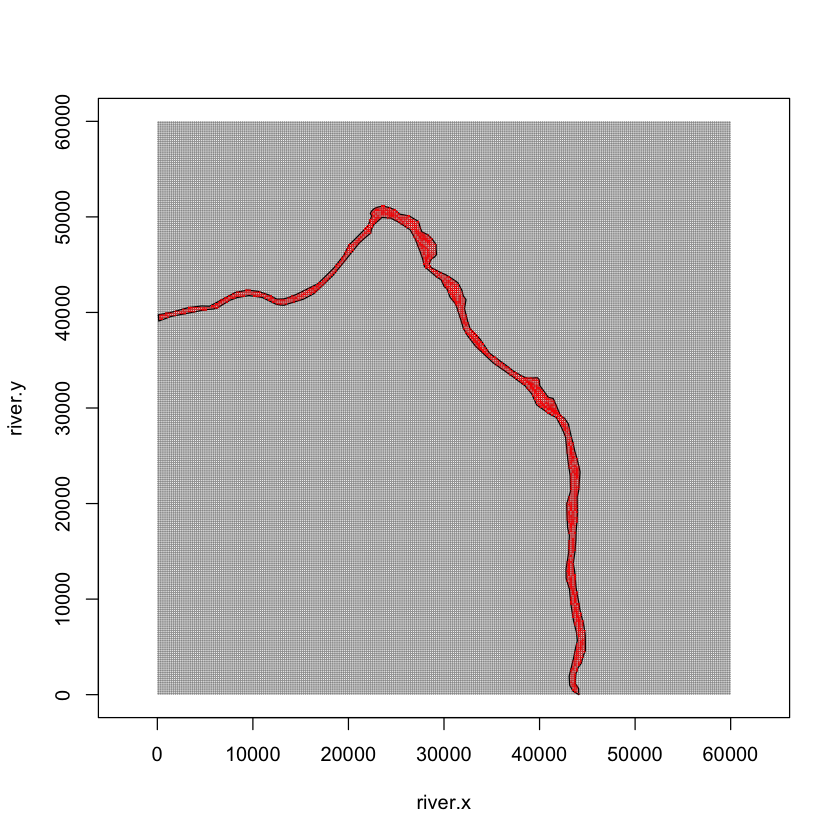

In [15]:
##-------------------------------find river cells within river geometry---------------------------------------##

## read into river geometry

river.geometry = read.csv(fname_river.geo)

river.geometry = river.geometry[, 2:3]

river.geometry.model = proj_to_model(model_origin, angle, river.geometry)
# colnames(river.geometry.model) = c("x", "y")

## look for cells inside river geometry
pts_in_poly = point.in.polygon(point.x = surface.x, point.y= surface.y, pol.x = river.geometry.model[, 1], pol.y = river.geometry.model[, 2])

river.x = surface.x[which(pts_in_poly==1)]
river.y = surface.y[which(pts_in_poly==1)]

# jpeg(fname_fig.grids, width=10,height=10,units='in',res=300,quality=100)
plot(river.x, river.y, xlim = c(0, xlen), ylim = c(0, ylen), asp = 1, col = "red", pch = 20, cex=0.05)
polygon(river.geometry.model[, 1], river.geometry.model[, 2], border = "black")
points(cells_model, pch = 20, cex=0.05)
points(river.x, river.y, col = "red", pch = 20, cex=0.05)

# grid(nx, ny, lty = "solid")

# dev.off()

In [16]:
river_cell_coord = cbind(
  face.cell.ids.final[which(pts_in_poly==1)],
  face.ids.final[which(pts_in_poly==1)],
                        river.x, 
                         river.y
                         )

colnames(river_cell_coord)=c("cell_id", "face_id", "x", "y")
river_cell_coord =river_cell_coord[order(river_cell_coord[,"cell_id"]), ]

## add river sections

In [17]:
##==============================add river regions===========================
# file.copy(material.file,river.material,overwrite=TRUE)


mass.coord = read.csv(fname_mass1_coord)
mass.coord[,"easting"] = mass.coord[,"easting"]-model_origin[1]
mass.coord[,"northing"] = mass.coord[,"northing"]-model_origin[2]

n.mass = nrow(mass.coord)

river.cells = river_cell_coord

nriver = nrow(river.cells)
river.section = rep(NA,nriver)
for (iriver in 1:nriver)
{
  mass.coord.index  =
    min(order((river.cells[iriver,"x"]-mass.coord[,"easting"])**2+
                (river.cells[iriver,"y"]-mass.coord[,"northing"])**2)[1:2])
  river.section[iriver] = mass.coord[mass.coord.index,1]
}

mass.sections = sort(unique(river.section))
nsection = length(mass.sections)

## plot mass1 with river cells

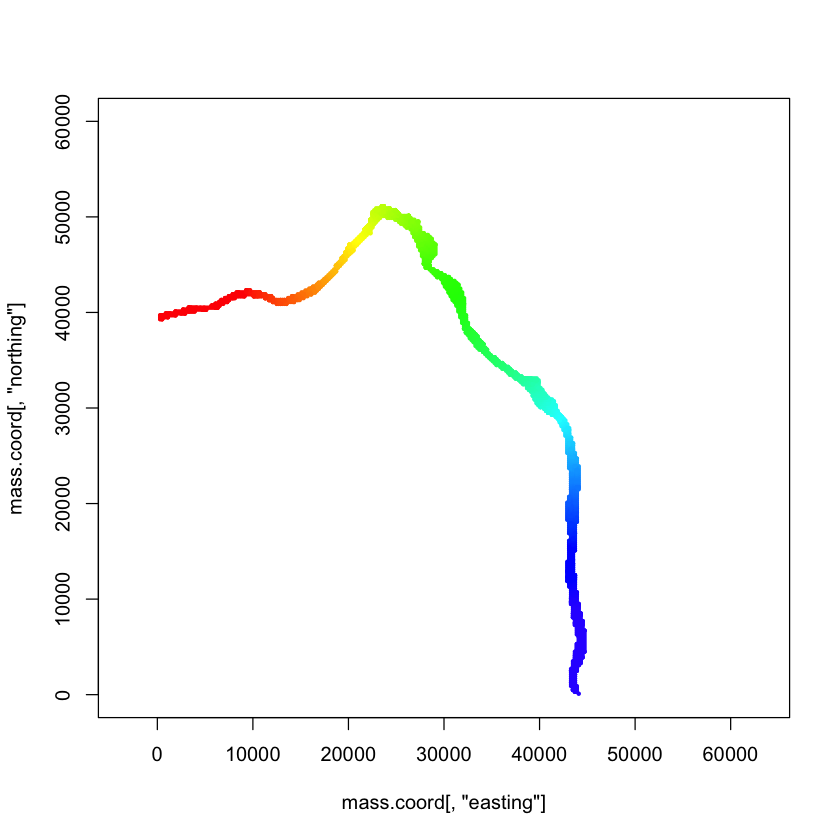

In [18]:
# plot mass1 pts along with river cells
colors = rainbow(nsection,start=0,end=0.7)
names(colors)=as.character(mass.sections)
# jpeg(fname_fig.river.mass1, width=8,height=8,units='in',res=300,quality=100)
plot(mass.coord[,"easting"],
     mass.coord[,"northing"],
     asp=1,cex=0.5,col="white",
     xlim=c(0,60000),
     ylim=c(0,60000)
)
points(river.cells[,"x"],river.cells[,"y"],
       col=colors[as.character(river.section)],
       cex=0.5,pch=16)
# dev.off()

## write material.h5 file

In [20]:
##------------------------------write hdf5 file-----------------------------------------------##

if(file.exists(fname_material_h5)) {file.remove(fname_material_h5)}
cell.ids = as.integer(c(cell.ids))
material.ids = as.integer(c(material.ids))

h5createFile(fname_material_h5)
h5createGroup(fname_material_h5,"Materials")
h5write(cell.ids,fname_material_h5,"Materials/Cell Ids",level=0)
h5write(material.ids,fname_material_h5,"Materials/Material Ids",level=0)

## write river faces to material
h5createGroup(fname_material_h5,"Regions")
for (isection in sort(mass.sections))
{
  river.group = paste("Regions/Mass1_",isection,sep="")
  h5createGroup(fname_material_h5,river.group)
  cells.in.mass = river.cells[which(river.section==isection),
                              c("cell_id")]
  faces.in.mass = river.cells[which(river.section==isection),
                              c("face_id")]
  ## needs to convert floating to integer
  cells.in.mass = as.integer(c(cells.in.mass))
  faces.in.mass = as.integer(c(faces.in.mass))
  h5write(cells.in.mass,fname_material_h5,
          paste(river.group,"/Cell Ids",sep=""),level=0)
  h5write(faces.in.mass,fname_material_h5,
          paste(river.group,"/Face Ids",sep=""),level=0)
}
H5close()

[1] TRUE

[1] TRUE

[1] TRUE